In [52]:
import os
import os.path as op
import mne
import numpy as np
import re
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from typing import Tuple, Iterator
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore

In [2]:
BIDS_ROOT = '../data/bids'
STIM_FREQS = np.array([50, 100, 150, 200, 250])
FS = 2000

## Functions

In [65]:
KeyType = Tuple[str, str, str, str]

def get_fpaths(bids_root) -> Iterator[KeyType]:
    # Get filepaths
    layout = BIDSLayout(bids_root, derivatives = True)
    fpaths = layout.get(scope = 'preprocessing',
                        extension = 'fif.gz',
                        return_type = 'filename')
    fpaths.pop(0)
    fpaths.pop(0) # CHANGE BACK
    
    # Get corresponding subject number
    filter_subs = re.compile('sub-(\d)_')
    subs = list(map(filter_subs.findall, fpaths))
    subs = list(itertools.chain(*subs))
    
    # Get corresponding run number
    filter_runs = re.compile('run-(\d)')
    runs = list(map(filter_runs.findall, fpaths))
    runs = list(itertools.chain(*runs))
    
    for i in range(len(fpaths)):
        key = (fpaths[i], subs[i], 'tasks', runs[i])
        yield key

def load_fif(fname):
    epochs = mne.read_epochs(fname)
    return epochs

def get_power_at_stim_freqs(epochs, stim_freqs):
    n_cycles = stim_freqs / 7.  # different number of cycle per frequency
    power = tfr_morlet(epochs, 
                       freqs = stim_freqs, 
                       n_cycles = n_cycles, 
                       use_fft = True,
                       return_itc = False, 
                       decim = 3, 
                       n_jobs = 1,
                       average = False)

    return power

## Compute power

In [66]:
# powers = []
# events = []
for (fpath, sub, task, run) in get_fpaths(BIDS_ROOT):
    epochs = load_fif(fpath)
    epochs = epochs.crop(tmin = 0)
#     events.append(mne.read_events(fpath)) #CHANGEBACK
    events = mne.read_events(fpath)
    power = get_power_at_stim_freqs(epochs, STIM_FREQS)
    log_power = np.log10(power)
#     powers.append(log_power) #CHANGEBACK
    break

Reading /Users/nusbaumlab/src/pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-3/sub-3_task-pitch_run-1_desc-clean_epo.fif.gz ...


/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
2333 matching events found
No baseline correction applied
0 projection items activated


/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_48951/4121053786.py:7: RuntimeWarning: This filename (/Users/nusbaumlab/src/pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-3/sub-3_task-pitch_run-1_desc-clean_epo.fif.gz) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(fpath)


Not setting metadata


## Shape data for decoder

In [68]:
# Get some information
power = log_power 
n_epochs = np.shape(power)[0]
n_channels = np.shape(power)[1]
n_freqs = np.shape(power)[2]
n_windows = np.shape(power)[3]

# Reshape for classifier
X = power.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order

In [69]:
# Create array of condition labels
labels = pd.Series(events[:, 2])
labels = labels.replace({10001 : 0, 10002 : 1, 10003 : 2, 10004 : 3, 10005 : 4})
y = labels.to_numpy()

In [70]:
# Transform y, use sklearn func to make sure its in the right format
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [72]:
np.shape(y)

(2333,)

## Decode

In [75]:
n_stimuli = 5
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimator")
time_decod = SlidingEstimator(clf)

print("Applying cross-validation")
scores = cross_val_multiscore(
    time_decod,
    X, # a trials x features x time array
    y, # an (n_trials,) array of integer condition labels
    cv = 5, # use stratified 5-fold cross-validation
#     scoring = 'balanced_accuracy',
    #n_jobs = 3, # use all available CPU cores
#     verbose = 3,
)
scores = np.mean(scores, axis = 0) # average across cv splits

Creating sliding estimator
Applying cross-validation


  0%|          | Fitting SlidingEstimator : 0/167 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/167 [00:00<?,       ?it/s]

ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets

Text(0.5, 1.0, 'Sensor space decoding')

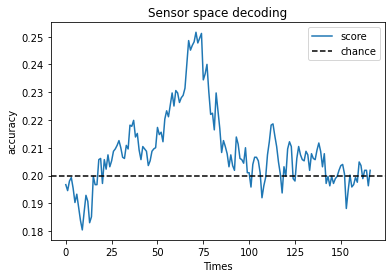

In [74]:
# plot
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

In [64]:
np.shape(y)

(4553,)

In [56]:
range(len(scores))

range(0, 167)